# Attention weight density analysis
## Treating seeds as subjects

In [1]:
from lstnn.compare_rdms import get_transformer_weights
from lstnn.dataset import get_dataset
import numpy as np
import matplotlib.pyplot as plt
import pingouin as pg
import seaborn as sns
import pandas as pd

data_dir = "/home/lukeh/projects/LSTNN/data/"
rdm_method_ann = "euclidean"
pe = "2dpe"
epoch = 4000
# load test puzzles as a torch ds
LST_puzzle_ds = get_dataset(f"{data_dir}nn/puzzle_data_original.csv")

# Target/ Probe analysis

## Target column vs. all other columns

In [2]:
from lstnn.verify_LST import verify_LST
from lstnn.dataset import get_dataset
import numpy as np
import matplotlib.pyplot as plt
import pingouin as pg
import seaborn as sns
import pandas as pd


# load test puzzles as a torch ds
LST_puzzle_ds = get_dataset(f"{data_dir}nn/puzzle_data_original.csv")

results = []

# get ANN weights
ann_weights = get_transformer_weights(LST_puzzle_ds, pe, epoch)
attn = ann_weights["attn"].copy()
n_seeds = attn.shape[0]
n_layers = attn.shape[1]

/home/lukeh/projects/LSTNN/lstnn/compare_rdms.py:214: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(
/home/lukeh/miniconda3/envs/lstann/lib/

In [3]:
for s in range(n_seeds):
    for p in range(108):

        # ATTN data
        data = attn[s, :, p, :]

         # average across layers
        data = np.mean(data, axis=0) 

        # reshape to attention matrix
        data = data.reshape(16, 16)

        # find the question mark for this puzzle
        target_index = np.where(LST_puzzle_ds.print_puzzle(p)[0].reshape(-1) == 5)[0][0]
        
        # get the mean of the target col
        target_mean = np.mean(data[:, target_index])
        other_mean = np.mean(data[:, ~target_index])

        _df = pd.DataFrame()
        _df["seed"] = [s]
        _df["puzzle"] = p
        _df["target"] = True
        _df["value"] = target_mean
        results.append(_df)

        _df = pd.DataFrame()
        _df["seed"] = [s]
        _df["puzzle"] = p
        _df["target"] = False
        _df["value"] = other_mean
        results.append(_df)

target_results = pd.concat(results)
target_results.head()

,seed,puzzle,target,value
0,0,0,True,0.260749
0,0,0,False,0.033892
0,0,1,True,0.261718
0,0,1,False,0.023242
0,0,2,True,0.270962


,seed,target,puzzle,value
0,0,False,53.5,0.036045
1,0,True,53.5,0.278410
2,1,False,53.5,0.035786


(30, 4)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,10.121774,14,two-sided,8.039151e-08,"[0.15, 0.22]",3.723929,1.722e+05,1.0


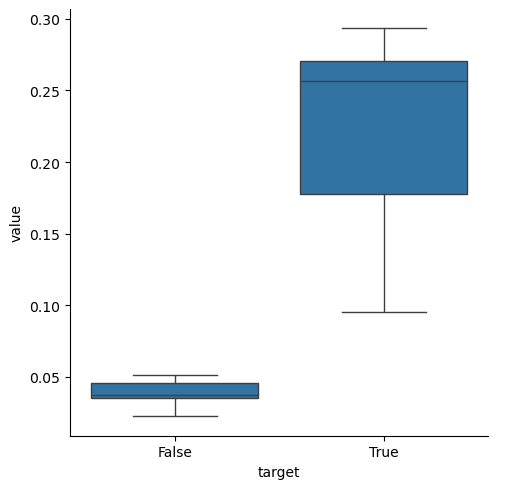

In [17]:
import pingouin as pg
data = target_results.groupby(["seed","target"]).mean(numeric_only=False).reset_index()
display(data.head(3))
print(data.shape)
sns.catplot(data=data, y="value", x="target", dodge=True, kind="box")
display(pg.ttest(x=data.loc[data.target==True, "value"].values,
         y=data.loc[data.target==False, "value"].values, paired=True))


# Contrast conditions

In [5]:
from lstnn.compare_rdms import get_transformer_rdms
from lstnn.verify_LST import verify_LST
from lstnn.dataset import get_dataset
import numpy as np
import matplotlib.pyplot as plt
import pingouin as pg
import seaborn as sns
import pandas as pd


# load test puzzles as a torch ds
LST_puzzle_ds = get_dataset(f"{data_dir}nn/puzzle_data_original.csv")

results = []
n_seeds = attn.shape[0]
n_layers = attn.shape[1]

for s in range(n_seeds):
    for p in range(108):

        # ATTN data
        data = attn[s, :, p, :]
        data = np.mean(data, axis=0)

        # reshape to attention matrix
        data = data.reshape(16, 16)

        # find the question mark for this puzzle
        target_index = np.where(LST_puzzle_ds.print_puzzle(p)[0].reshape(-1) == 5)[0][0]

        # find the row of interest
        # these should be sequential indicies - as the reshape doesn't mix up rows
        row_of_interest, col_of_interest = np.where(LST_puzzle_ds.print_puzzle(p)[0] == 5)
        row_index = np.zeros((4,4))
        row_index[row_of_interest[0], :] = True

        # find the cols of interest - these are not sequential
        col_index = np.zeros((4,4))
        col_index[:, col_of_interest[0]] = True

        # Assign values to a dict
        values = {}

        # take the entire ("all") row/ col (includes target-target)
        # same as above
        values["all"]  = data[:, target_index]

        # take only values in the row (does not include target-target)
        idx = np.where(row_index.reshape(-1))[0]
        idx = np.delete(idx, np.where(idx==target_index))
        values["row"]  = data[idx, target_index]

        # take only values in the col (does not include target-target)
        idx = np.where(col_index.reshape(-1))[0]
        idx = np.delete(idx, np.where(idx==target_index))
        values["col"]  = data[idx, target_index]
        
        if p < 36:
            condition = 1
        elif 36 <= p < 72:
            condition = 2
        else:
            condition = 3

        # get strat:
        strat = verify_LST(LST_puzzle_ds.print_puzzle(p)[0].numpy())
        for scope in ["all", "row", "col"]:
            _df = pd.DataFrame()
            _df["seed"] = [s]
            _df["puzzle"] = p
            _df["strat"] = strat[2]
            _df["cond"] = condition
            _df["scope"] = scope
            _df["mean_value"] = np.mean(values[scope])
            results.append(_df)
results = pd.concat(results)
results.head()

,seed,puzzle,strat,cond,scope,mean_value
0,0,0,Binary-col,1,all,0.260749
0,0,0,Binary-col,1,row,0.283369
0,0,0,Binary-col,1,col,0.281708
0,0,1,Binary-row,1,all,0.261718
0,0,1,Binary-row,1,row,0.314470


## Binary as an illustrative example of attention scores

/tmp/ipykernel_172953/1792158481.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


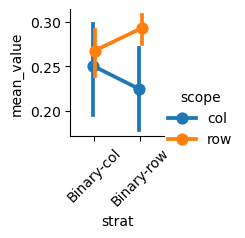

/tmp/ipykernel_172953/1792158481.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


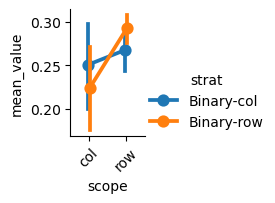

In [6]:
plot = results.loc[results.strat.str.startswith("Binary")]
plot = plot.loc[plot.scope != "all"]
plot = plot.groupby(["seed", "strat", "scope"]).mean().reset_index()
#g = sns.catplot(data=plot, y="mean_value", x="strat", hue="scope", height=2, kind="strip", errorbar=None, sharey=True, dodge=True)
g = sns.catplot(data=plot, y="mean_value", x="strat", hue="scope", height=2, kind="point", dodge=True)
# Rotate x-ticks for all subplots
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()


plot = results.loc[results.strat.str.startswith("Binary")]
plot = plot.loc[plot.scope != "all"]
plot = plot.groupby(["seed", "strat", "scope"]).mean().reset_index()
#g = sns.catplot(data=plot, y="mean_value", x="strat", hue="scope", height=2, kind="strip", errorbar=None, sharey=True, dodge=True)
g = sns.catplot(data=plot, y="mean_value", x="scope", hue="strat", height=2, kind="point", dodge=True)
# Rotate x-ticks for all subplots
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

In [7]:
print("ROW")
data = results.loc[results.strat.str.startswith("Binary")]
data = data.loc[(data.scope == "row")]
data = data.groupby(["seed", "strat", "scope"]).mean().reset_index()
data.head()
display(pg.ttest(x=data.loc[data.strat=="Binary-col", "mean_value"].values,
         y=data.loc[data.strat=="Binary-row", "mean_value"].values, paired=True))

print("COL")
data = results.loc[results.strat.str.startswith("Binary")]
data = data.loc[(data.scope == "col")]
data = data.groupby(["seed", "strat", "scope"]).mean().reset_index()
data.head()
display(pg.ttest(x=data.loc[data.strat=="Binary-col", "mean_value"].values,
         y=data.loc[data.strat=="Binary-row", "mean_value"].values, paired=True))

ROW


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.090534,14,two-sided,0.007981,"[-0.04, -0.01]",0.597084,6.708,0.57633


COL


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.255552,14,two-sided,0.040626,"[0.0, 0.05]",0.265663,1.806,0.160315


# Attention across conditions

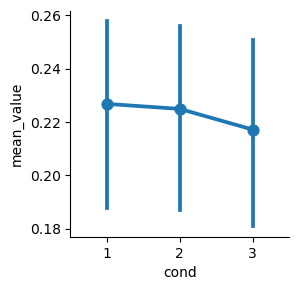

In [8]:
data = results.loc[(results.scope == "all")]
data = data.groupby(["seed", "cond"]).mean(numeric_only=True).reset_index()
sns.catplot(data=data, y="mean_value", x="cond", height=3, kind="point", sharey=False)


### Within-subject variance is important for this effect:

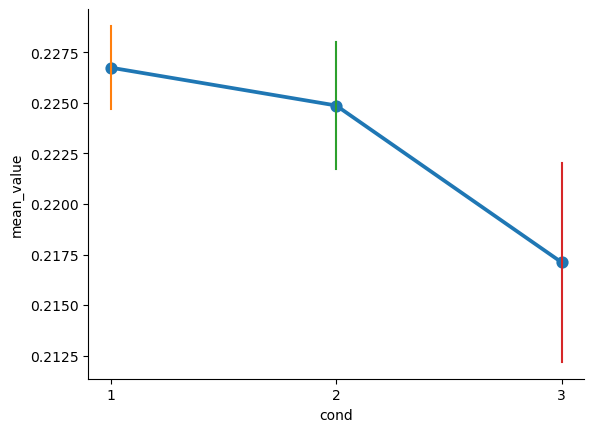

In [9]:
def cousineau_morey_ci(data):
    n_subjects = data.shape[0]

    # Normalize the data by subtracting the subject mean and adding the grand mean
    subject_means = np.mean(data, axis=1)
    grand_mean = np.mean(data)
    normalized_data = (data - subject_means[:, np.newaxis]) + grand_mean

    # CI = Mean +/- t(1-alpha/2, n-1) * SD / sqrt(n) * sqrt(c / (c-1))
    critical_value = 1.96
    m = np.mean(normalized_data, axis=0)
    sem = np.std(normalized_data, axis=0) / np.sqrt(n_subjects)
    correction = np.sqrt(data.shape[1] / (data.shape[1]-1))

    # Calculate the confidence intervals
    ci_lower = m - (critical_value * sem * correction)
    ci_upper = m + (critical_value * sem * correction)

    return ci_lower, ci_upper


y = "mean_value"
ax = sns.pointplot(data=data, x="cond", y=y, errorbar=None)

# plot within-subject CIs
ci_data = np.vstack((data.loc[data.cond == 1, y].values,
                    data.loc[data.cond == 2, y].values,
                    data.loc[data.cond == 3, y].values)).T
cis_upper, cis_lower = cousineau_morey_ci(ci_data)
for j in range(3):
    ax.plot([j, j], [cis_upper[j], cis_lower[j]])
    
sns.despine(ax=ax)

In [10]:
data = results.loc[(results.scope == "all")]
data = data.groupby(["seed", "cond"]).mean(numeric_only=True).reset_index()
display(pg.rm_anova(data=data, dv="mean_value", within="cond", subject="seed"))
display(pg.friedman(data=data, dv="mean_value", within="cond", subject="seed"))

/home/lukeh/miniconda3/envs/lstann/lib/python3.9/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,cond,2,28,7.320751,0.00277,0.003817,0.533848


,Source,W,ddof1,Q,p-unc
Friedman,cond,0.457778,2,13.733333,0.001042


In [11]:
# ttests
print("1 v. 2")
display(pg.ttest(x=data.loc[data.cond==1, "mean_value"].values,
         y=data.loc[data.cond==2, "mean_value"].values, paired=True))

print("2 v. 3")
display(pg.ttest(x=data.loc[data.cond==2, "mean_value"].values,
         y=data.loc[data.cond==3, "mean_value"].values, paired=True))

print("1 v. 3")
display(pg.ttest(x=data.loc[data.cond==1, "mean_value"].values,
         y=data.loc[data.cond==3, "mean_value"].values, paired=True))

1 v. 2


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.224121,14,two-sided,0.043104,"[0.0, 0.0]",0.026809,1.725,0.051077


2 v. 3


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.251408,14,two-sided,0.040945,"[0.0, 0.02]",0.111015,1.795,0.06864


1 v. 3


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.248831,14,two-sided,0.005826,"[0.0, 0.02]",0.138789,8.709,0.079287


# Publication plot

/tmp/ipykernel_172953/1200947289.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=["Non-Target", "Target"], fontsize=9, rotation=25)
/tmp/ipykernel_172953/1200947289.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=["Column", "Row"], fontsize=9)
/tmp/ipykernel_172953/1200947289.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=["Column", "Row"], fontsize=9)
/tmp/ipykernel_172953/1200947289.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=["1-vec", "2-vec", "3-vec"], fontsize=9)


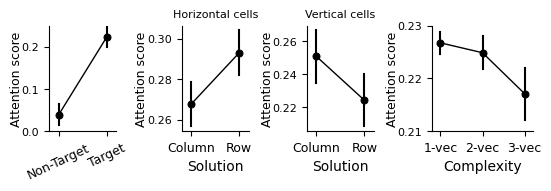

In [12]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#88mm = 3.46 inch

plt.rcParams['svg.fonttype'] = 'none'
pal = [(0.918, 0.451, 0.553),
       (0.537, 0.671, 0.890)]

# create figure
fig, axs = plt.subplot_mosaic("""
                              AABBCCDDD
                              """,
                              figsize=(5.4, 1.8),
                              constrained_layout=True)

ax = axs["A"]
y="value"
data = target_results.groupby(["seed","target"]).mean(numeric_only=False).reset_index()
sns.pointplot(data=data, x="target", y=y, errorbar=None, color="k", ax=ax, linewidth=1, markersize=5)

# plot within-subject CIs
ci_data = np.vstack((data.loc[data.target == False, y].values,
                    data.loc[data.target == True, y].values)).T
cis_upper, cis_lower = cousineau_morey_ci(ci_data)
for j in range(2):
    ax.plot([j, j], [cis_upper[j], cis_lower[j]], color="k")

ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_ylabel("Attention score", fontsize=9, labelpad=-1)
ax.set_xticklabels(labels=["Non-Target", "Target"], fontsize=9, rotation=25)
ax.set_xlabel("")
ax.set_xlim([-0.2, 1.2])
ax.set_ylim([0, 0.25])
sns.despine(ax=ax)

ax = axs["B"]
y="mean_value"
data = results.loc[results.strat.str.startswith("Binary")]
data = data.loc[(data.scope == "row")]
data = data.groupby(["seed", "strat", "scope"]).mean().reset_index()
sns.pointplot(data=data, x="strat", y=y, errorbar=None, ax=ax, color="k", linewidth=1, markersize=5, legend=False)

# plot within-subject CIs
ci_data = np.vstack((data.loc[data.strat == "Binary-col", y].values,
                    data.loc[data.strat == "Binary-row", y].values)).T
cis_upper, cis_lower = cousineau_morey_ci(ci_data)
for j in range(2):
    ax.plot([j, j], [cis_upper[j], cis_lower[j]], color="k")

ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_ylabel("Attention score", fontsize=9, labelpad=-1)
ax.set_xticklabels(labels=["Column", "Row"], fontsize=9)
ax.set_xlabel("Solution")
ax.set_title("Horizontal cells", fontsize=8)
ax.set_xlim([-0.2, 1.2])
sns.despine(ax=ax)

ax = axs["C"]

data = results.loc[results.strat.str.startswith("Binary")]
data = data.loc[(data.scope == "col")]
data = data.groupby(["seed", "strat", "scope"]).mean().reset_index()
sns.pointplot(data=data, x="strat", y=y, errorbar=None, ax=ax, color="k", linewidth=1, markersize=5, legend=False)

# plot within-subject CIs
ci_data = np.vstack((data.loc[data.strat == "Binary-col", y].values,
                    data.loc[data.strat == "Binary-row", y].values)).T
cis_upper, cis_lower = cousineau_morey_ci(ci_data)
for j in range(2):
    ax.plot([j, j], [cis_upper[j], cis_lower[j]], color="k")

ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_ylabel("Attention score", fontsize=9, labelpad=-1)
ax.set_xticklabels(labels=["Column", "Row"], fontsize=9)
ax.set_xlabel("Solution")
ax.set_xlim([-0.2, 1.2])
ax.set_title("Vertical cells", fontsize=8)
sns.despine(ax=ax)

ax = axs["D"]

data = results.loc[(results.scope == "all")]
data = data.groupby(["seed", "cond"]).mean(numeric_only=True).reset_index()
sns.pointplot(data=data, x="cond", y=y, errorbar=None, ax=ax, color="k", linewidth=1, markersize=5, legend=False)

# plot within-subject CIs
ci_data = np.vstack((data.loc[data.cond == 1, y].values,
                    data.loc[data.cond == 2, y].values,
                    data.loc[data.cond == 3, y].values)).T
cis_upper, cis_lower = cousineau_morey_ci(ci_data)
for j in range(3):
    ax.plot([j, j], [cis_upper[j], cis_lower[j]], color="k")

ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_ylabel("Attention score", fontsize=9, labelpad=-1)
ax.set_yticks([0.21, 0.22, 0.23])
ax.set_xticklabels(labels=["1-vec", "2-vec", "3-vec"], fontsize=9)
ax.set_xlabel("Complexity")
ax.set_xlim([-0.2, 2.2])
sns.despine(ax=ax)
plt.savefig(f"../figures/attention_stats.svg", bbox_inches='tight')
#plt.savefig(f"../figures/l2norm.jpeg", bbox_inches='tight', dpi=1200)
plt.show()

# Informative vs. non-informative cells
I think this is a clearer way to test the middle panel's idea.

In [13]:
from lstnn.compare_rdms import get_transformer_rdms
from lstnn.verify_LST import verify_LST
from lstnn.dataset import get_dataset
import numpy as np
import matplotlib.pyplot as plt
import pingouin as pg
import seaborn as sns
import pandas as pd


# load test puzzles as a torch ds
LST_puzzle_ds = get_dataset(f"{data_dir}nn/puzzle_data_original.csv")

inf_results = []
n_seeds = attn.shape[0]
n_layers = attn.shape[1]

for s in range(n_seeds):
    for p in range(36):

        # ATTN data
        data = attn[s, :, p, :]
        data = np.mean(data, axis=0)

        # reshape to attention matrix
        data = data.reshape(16, 16)

        # find the question mark for this puzzle
        target_index = np.where(LST_puzzle_ds.print_puzzle(p)[0].reshape(-1) == 5)[0][0]

        # get strat:
        strat = verify_LST(LST_puzzle_ds.print_puzzle(p)[0].numpy())
        # find the row of interest
        # these should be sequential indicies - as the reshape doesn't mix up rows
        row_of_interest, col_of_interest = np.where(LST_puzzle_ds.print_puzzle(p)[0] == 5)
        row_index = np.zeros((4,4))
        row_index[row_of_interest[0], :] = True

        # find the cols of interest - these are not sequential
        col_index = np.zeros((4,4))
        col_index[:, col_of_interest[0]] = True

        # take only values in the row (does not include target-target)
        idx = np.where(row_index.reshape(-1))[0]
        idx = np.delete(idx, np.where(idx==target_index))
        row_values  = data[idx, target_index]

        # take only values in the col (does not include target-target)
        idx = np.where(col_index.reshape(-1))[0]
        idx = np.delete(idx, np.where(idx==target_index))
        col_values  = data[idx, target_index]

        # take all other values

        if strat[2] == "Binary-row":
            info_cells = np.mean(row_values)
            #non_cells = np.mean(col_values)
            inv_index = (row_index * -1 )+ 1
            idx = np.where(inv_index.reshape(-1))[0]
            values  = data[idx, target_index]
            non_cells = np.mean(values)
        elif strat[2] == "Binary-col":
            #non_cells = np.mean(row_values)
            info_cells = np.mean(col_values)
            inv_index = (col_index * -1 )+ 1
            idx = np.where(inv_index.reshape(-1))[0]
            values  = data[idx, target_index]
            non_cells = np.mean(values)

        # # save 
        # _df = pd.DataFrame()
        # _df["seed"] = [s]
        # _df["puzzle"] = p
        # _df["cond"] = 1
        # _df["cell"] = "target"
        # _df["value"] = data[target_index, target_index]
        # results.append(_df)

        # save 
        _df = pd.DataFrame()
        _df["seed"] = [s]
        _df["puzzle"] = p
        _df["cond"] = 1
        _df["cell"] = "informative"
        _df["value"] = info_cells
        inf_results.append(_df)

        # save
        _df = pd.DataFrame()
        _df["seed"] = [s]
        _df["puzzle"] = p
        _df["cond"] = 1
        _df["cell"] = "uninformative"
        _df["value"] = non_cells
        inf_results.append(_df)
inf_results = pd.concat(inf_results)
inf_results.head()

,seed,puzzle,cond,cell,value
0,0,0,1,informative,0.281708
0,0,0,1,uninformative,0.254007
0,0,1,1,informative,0.314470
0,0,1,1,uninformative,0.247187
0,0,2,1,informative,0.295081


,seed,cell,puzzle,cond,value
0,0,informative,17.5,1.0,0.312574
1,0,uninformative,17.5,1.0,0.276825
2,1,informative,17.5,1.0,0.197251
3,1,uninformative,17.5,1.0,0.059004
4,2,informative,17.5,1.0,0.320000


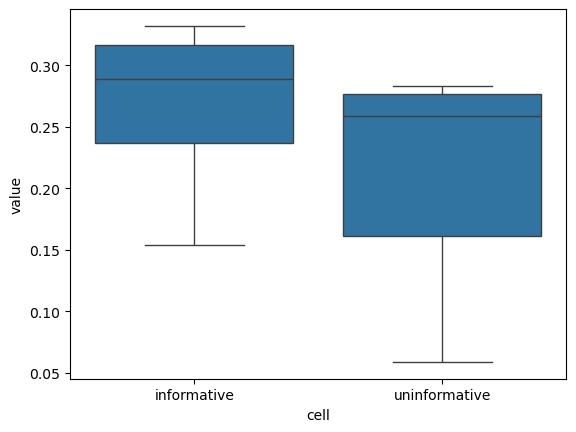

In [14]:
x = inf_results.groupby(["seed", "cell"]).mean(numeric_only=True).reset_index()
sns.boxplot(data=x, y="value", x="cell")
x.head()

In [15]:
x = inf_results.groupby(["seed", "cell"]).mean(numeric_only=True).reset_index()
x.head()
display(pg.ttest(x=x.loc[x.cell=="informative", "value"].values,
                 y=x.loc[x.cell=="uninformative", "value"].values, paired=True))

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,5.809686,14,two-sided,0.000045,"[0.04, 0.08]",0.857274,576.593,0.869811


# Publication plot

/tmp/ipykernel_172953/2807785216.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=["Non-Target", "Target"], fontsize=9, rotation=25)
/tmp/ipykernel_172953/2807785216.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=["Non-critical", "Critical"], fontsize=9, rotation=25)
/tmp/ipykernel_172953/2807785216.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=["1-vec", "2-vec", "3-vec"], fontsize=9)


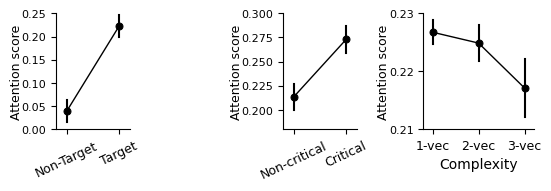

In [18]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#88mm = 3.46 inch

plt.rcParams['svg.fonttype'] = 'none'
pal = [(0.918, 0.451, 0.553),
       (0.537, 0.671, 0.890)]

# create figure
fig, axs = plt.subplot_mosaic("""
                              AABBCCDDD
                              """,
                              figsize=(5.4, 1.8),
                              constrained_layout=True)

ax = axs["A"]
y="value"
data = target_results.groupby(["seed","target"]).mean(numeric_only=False).reset_index()
sns.pointplot(data=data, x="target", y=y, errorbar=None, color="k", ax=ax, linewidth=1, markersize=5)

# plot within-subject CIs
ci_data = np.vstack((data.loc[data.target == False, y].values,
                    data.loc[data.target == True, y].values)).T
cis_upper, cis_lower = cousineau_morey_ci(ci_data)
for j in range(2):
    ax.plot([j, j], [cis_upper[j], cis_lower[j]], color="k")

ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_ylabel("Attention score", fontsize=9, labelpad=-1)
ax.set_xticklabels(labels=["Non-Target", "Target"], fontsize=9, rotation=25)
ax.set_xlabel("")
ax.set_xlim([-0.2, 1.2])
ax.set_ylim([0, 0.25])
sns.despine(ax=ax)

ax = axs["B"]
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
sns.despine(left=True, bottom=True, ax=ax)

ax = axs["C"]

data = inf_results.groupby(["seed", "cell"]).mean(numeric_only=True).reset_index()
sns.pointplot(data=data, x="cell", y="value", errorbar=None, 
              order=["uninformative", "informative"], ax=ax, color="k", linewidth=1, markersize=5, legend=False)

# plot within-subject CIs
ci_data = np.vstack((data.loc[data.cell == "uninformative", y].values,
                    data.loc[data.cell == "informative", y].values)).T
cis_upper, cis_lower = cousineau_morey_ci(ci_data)
for j in range(2):
    ax.plot([j, j], [cis_upper[j], cis_lower[j]], color="k")

ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_ylabel("Attention score", fontsize=9, labelpad=-1)
ax.set_xticklabels(labels=["Non-critical", "Critical"], fontsize=9, rotation=25)
ax.set_xlabel("")
ax.set_xlim([-0.2, 1.2])
ax.set_ylim([0.18, 0.3])
sns.despine(ax=ax)

ax = axs["D"]

data = results.loc[(results.scope == "all")]
data = data.groupby(["seed", "cond"]).mean(numeric_only=True).reset_index()
sns.pointplot(data=data, x="cond", y="mean_value", errorbar=None, ax=ax, color="k", linewidth=1, markersize=5, legend=False)

# plot within-subject CIs
ci_data = np.vstack((data.loc[data.cond == 1, "mean_value"].values,
                    data.loc[data.cond == 2, "mean_value"].values,
                    data.loc[data.cond == 3, "mean_value"].values)).T
cis_upper, cis_lower = cousineau_morey_ci(ci_data)
for j in range(3):
    ax.plot([j, j], [cis_upper[j], cis_lower[j]], color="k")

ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_ylabel("Attention score", fontsize=9, labelpad=-1)
ax.set_yticks([0.21, 0.22, 0.23])
ax.set_xticklabels(labels=["1-vec", "2-vec", "3-vec"], fontsize=9)
ax.set_xlabel("Complexity")
ax.set_xlim([-0.2, 2.2])
sns.despine(ax=ax)
plt.savefig(f"../figures/attention_stats.svg", bbox_inches='tight')
plt.show()